## データの読込

In [1]:
import pandas as pd
df = pd.read_csv("vgsales-12-4-2019.csv")
df.head(3)

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,...,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,...,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,...,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,...,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg


## 精度評価

In [22]:
import os
import random
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import warnings
warnings.simplefilter('ignore')

In [23]:
# シード値の固定
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df.dropna(subset=["Global_Sales"]).drop(["Global_Sales",  "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"], axis=1).select_dtypes(include="number"), 
                                                    df.dropna(subset=["Global_Sales"])["Global_Sales"],  
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    random_state=42
                                                    ) 

In [25]:
# データセットを登録
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [26]:
params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': 'rmse',  # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          }

In [27]:
lgb_results = {}                                    # 学習の履歴を入れる入物

model = lgb.train(
                  params=params,                    # ハイパーパラメータをセット
                  train_set=lgb_train,              # 訓練データを訓練用にセット
                  valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                  valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                  num_boost_round=100,              # 計算回数
                  early_stopping_rounds=50,         # アーリーストッピング設定
                  evals_result=lgb_results,
                  verbose_eval=-1,                           # ログを最後の1つだけ表示
                  )  

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the train set: 13590, number of used features: 5
[LightGBM] [Info] Start training from score 0.366483
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174516	Test's rmse: 0.245209


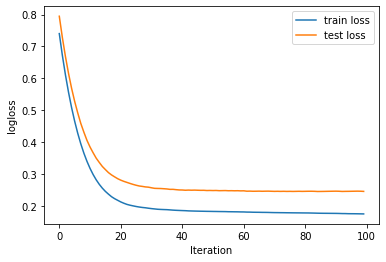

In [28]:
loss_train = lgb_results['Train']['rmse']
loss_test = lgb_results['Test']['rmse']   
  
fig = plt.figure()
ax1 = fig.add_subplot(111)
  
ax1.set_xlabel('Iteration')
ax1.set_ylabel('logloss')
 
ax1.plot(loss_train, label='train loss')
ax1.plot(loss_test, label='test loss')
 
plt.legend()
plt.show()

In [29]:
y_pred = model.predict(X_test)

In [30]:
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", round(mae, 4))

mse = mean_squared_error(y_test, y_pred)
print("MSE:", round(mse, 4))

rmse1 = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE 1:", round(rmse1, 4))

rmse2 = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE 2:", round(rmse2, 4))

r2score = r2_score(y_test, y_pred)
print("R2 score:", round(r2score, 4))

MAE: 0.0183
MSE: 0.0601
RMSE 1: 0.2452
RMSE 2: 0.2452
R2 score: 0.9205


### メトリクスを変えて実施

In [31]:
params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰分類を指定
          'metric': 'mae',  # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          }

In [32]:
lgb_results = {}                                    # 学習の履歴を入れる入物

model = lgb.train(
                  params=params,                    # ハイパーパラメータをセット
                  train_set=lgb_train,              # 訓練データを訓練用にセット
                  valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                  valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                  num_boost_round=100,              # 計算回数
                  early_stopping_rounds=50,         # アーリーストッピング設定
                  evals_result=lgb_results,
                  verbose_eval=-1,                           # ログを最後の1つだけ表示
                  )  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the train set: 13590, number of used features: 5
[LightGBM] [Info] Start training from score 0.366483
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[97]	Train's l1: 0.0145091	Test's l1: 0.0182076


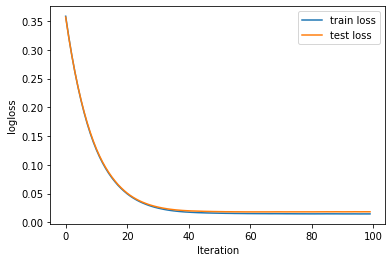

In [33]:
loss_train = lgb_results['Train']['l1']
loss_test = lgb_results['Test']['l1']   
  
fig = plt.figure()
ax1 = fig.add_subplot(111)
  
ax1.set_xlabel('Iteration')
ax1.set_ylabel('logloss')
 
ax1.plot(loss_train, label='train loss')
ax1.plot(loss_test, label='test loss')
 
plt.legend()
plt.show()

In [34]:
y_pred = model.predict(X_test)

In [35]:
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", round(mae, 4))

mse = mean_squared_error(y_test, y_pred)
print("MSE:", round(mse, 4))

rmse1 = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE 1:", round(rmse1, 4))

rmse2 = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE 2:", round(rmse2, 4))

r2score = r2_score(y_test, y_pred)
print("R2 score:", round(r2score, 4))

MAE: 0.0182
MSE: 0.0604
RMSE 1: 0.2457
RMSE 2: 0.2457
R2 score: 0.9202


## 極端な例

### パターン1

In [36]:
true = [100, 2]
pred = [1, 1]

print("MAE:", mean_absolute_error(true, pred))

print("MSE:", mean_squared_error(true, pred))

print("RMSE:", mean_squared_error(true, pred, squared=False))

print("R2 score:", r2_score(true, pred))

MAE: 50.0
MSE: 4901.0
RMSE: 70.00714249274856
R2 score: -1.0412328196584757


### パターン2

In [37]:
true = [100, 99]
pred = [1, 1]

print("MAE:", mean_absolute_error(true, pred))

print("MSE:", mean_squared_error(true, pred))

print("RMSE:", mean_squared_error(true, pred, squared=False))

print("R2 score:", r2_score(true, pred))

MAE: 98.5
MSE: 9702.5
RMSE: 98.50126902735822
R2 score: -38809.0


## R2スコア補足

### パターン1 誤差大きいものと小さいものがある、予測は実績と相関がない

In [38]:
true = [100, 2]
pred = [1, 1]

print("実績: ", true)
print("予測: ", pred)
print("実績の平均: ", np.array([np.mean(true)] * len(true)).tolist() )
print()

a = np.sum(
                (
                    # 実績
                    np.array(true) - \
                 
                    # 予測
                    np.array(pred)
                ) 
            ** 2)
print("実績と予測の差(誤差)の総和の二乗: ", a) # 分子

b = np.sum( 
                (
                    # 実績
                    np.array(true)  \
                 
                   # 実績の平均値
                    - np.array([np.mean(true)] * len(true))
                )
             ** 2 )
print("実績と実績の平均値の差の総和の二乗: ", b) # 分母

score = 1 - a/b # R2 score
print("R2 Score: ", score)

実績:  [100, 2]
予測:  [1, 1]
実績の平均:  [51.0, 51.0]

実績と予測の差(誤差)の総和の二乗:  9802
実績と実績の平均値の差の総和の二乗:  4802.0
R2 Score:  -1.0412328196584757


### パターン2 誤差大きい、予測は実績と相関がない

In [39]:
true = [100, 99]
pred = [1, 1]

print("実績: ", true)
print("予測: ", pred)
print("実績の平均: ", np.array([np.mean(true)] * len(true)).tolist() )
print()

a = np.sum(
                (
                    # 実績
                    np.array(true) - \
                 
                    # 予測
                    np.array(pred)
                ) 
            ** 2)
print("実績と予測の差(誤差)の総和の二乗: ", a) # 分子

b = np.sum( 
                (
                    # 実績
                    np.array(true)  \
                 
                   # 実績の平均値
                    - np.array([np.mean(true)] * len(true))
                )
             ** 2 )
print("実績と実績の平均値の差の総和の二乗: ", b) # 分母

score = 1 - a/b # R2 score
print("R2 Score: ", score)

実績:  [100, 99]
予測:  [1, 1]
実績の平均:  [99.5, 99.5]

実績と予測の差(誤差)の総和の二乗:  19405
実績と実績の平均値の差の総和の二乗:  0.5
R2 Score:  -38809.0


### パターン3 誤差も少なく、予測と実績に相関がある

In [40]:
true = [1.5, 1.2]
pred = [1.4, 1.1]

print("実績: ", true)
print("予測: ", pred)
print("実績の平均: ", np.array([np.mean(true)] * len(true)).tolist() )
print()

a = np.sum(
                (
                    # 実績
                    np.array(true) - \
                 
                    # 予測
                    np.array(pred)
                ) 
            ** 2)
print("実績と予測の差(誤差)の総和の二乗: ", a) # 分子

b = np.sum( 
                (
                    # 実績
                    np.array(true)  \
                 
                   # 実績の平均値
                    - np.array([np.mean(true)] * len(true))
                )
             ** 2 )
print("実績と実績の平均値の差の総和の二乗: ", b) # 分母

score = 1 - a/b # R2 score
print("R2 Score: ", score)

実績:  [1.5, 1.2]
予測:  [1.4, 1.1]
実績の平均:  [1.35, 1.35]

実績と予測の差(誤差)の総和の二乗:  0.01999999999999999
実績と実績の平均値の差の総和の二乗:  0.04500000000000001
R2 Score:  0.5555555555555559


### パターン4 誤差は少ないが予測に相関がない

In [41]:
true = [1.5, 1.2]
pred = [1.0, 1.0]

print("実績: ", true)
print("予測: ", pred)
print("実績の平均: ", np.array([np.mean(true)] * len(true)).tolist() )
print()

a = np.sum(
                (
                    # 実績
                    np.array(true) - \
                 
                    # 予測
                    np.array(pred)
                ) 
            ** 2)
print("実績と予測の差(誤差)の総和の二乗: ", a) # 分子

b = np.sum( 
                (
                    # 実績
                    np.array(true)  \
                 
                   # 実績の平均値
                    - np.array([np.mean(true)] * len(true))
                )
             ** 2 )
print("実績と実績の平均値の差の総和の二乗: ", b) # 分母

score = 1 - a/b # R2 score
print("R2 Score: ", score)

実績:  [1.5, 1.2]
予測:  [1.0, 1.0]
実績の平均:  [1.35, 1.35]

実績と予測の差(誤差)の総和の二乗:  0.29
実績と実績の平均値の差の総和の二乗:  0.04500000000000001
R2 Score:  -5.444444444444442
